In [35]:
files = ['NG4STABLE.filtered_edits.csv', 'cLIDAR.filtered_edits.csv', 'eLIDAR.filtered_edits.csv', 'gLIDAR.filtered_edits.csv', 'AD2.filtered_edits.csv']
#files = ['NG4AVP.filtered_edits.csv','noAVP.filtered_edits.csv','AVP.filtered_edits.csv']
num_files=len(files)
base_dir='/Users/lsmille/Documents/REDI/final_2/'

In [36]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.multitest as mt

edit_map = {}
sample = 0
conds=1 #hardcoded #int(num_files/3)

print("# of files:", num_files)

for file in files:
    file = base_dir+file
    print(file)
    df = pd.read_csv(file, sep=",")
    for index, row in df.iterrows():
        pos = row['Position']
        reg = row['Region']

        bases = eval(row['BaseCount[A,C,G,T]'])
        sum_freq=sum(bases)

        if not reg in edit_map:
            edit_map[reg]={}
        if not pos in edit_map[reg]:
            edit_map[reg][pos]= { 'Reference': row['Reference'], 'Frequency': [0]*num_files, 'FisherM': [[0,0]]*num_files }

        if sum_freq<20 or (row['Reference'] == 'A' and bases[2]<1) or (row['Reference'] == 'T' and bases[1]<1):
            if reg in edit_map and pos in edit_map[reg]:
                edit_map[reg][pos]['Frequency'][sample]=None
            continue
        
        if row['Reference'] == 'A':
            edit_map[reg][pos]['Frequency'][sample]=bases[2]/(bases[0]+bases[2]) #row['Frequency']
            edit_map[reg][pos]['FisherM'][sample]=[sum_freq-bases[2], bases[2]] # 2 corresponds to position G
        elif row['Reference'] == 'T':
            edit_map[reg][pos]['Frequency'][sample]=bases[1]/(bases[3]+bases[1]) #row['Frequency']
            edit_map[reg][pos]['FisherM'][sample]=[sum_freq-bases[1], bases[1]] # 1 = position for C

    sample+=1
    del df

print('First step passed\n')

# of files: 5
/Users/lsmille/Documents/REDI/final_2/NG4STABLE.filtered_edits.csv
/Users/lsmille/Documents/REDI/final_2/cLIDAR.filtered_edits.csv
/Users/lsmille/Documents/REDI/final_2/eLIDAR.filtered_edits.csv
/Users/lsmille/Documents/REDI/final_2/gLIDAR.filtered_edits.csv
/Users/lsmille/Documents/REDI/final_2/AD2.filtered_edits.csv
First step passed



In [46]:
means = [None]*num_files
pvaluesx=[]
pvaluesy=[]
pvals=[]
pvals_all=[]
gene=[]
tables =[]
comparison = 0
comp_2 = 4
high_edit=0
total_pos=0
e=0.00000001

for region, positions in edit_map.items():
    for position, sitedata in positions.items():
        frequencies = sitedata['Frequency']

        #Based on Katrekar et al (https://doi.org/10.1038/s41592-019-0323-0) protocol. Only look at sites shared by all conditions
        #Also based on Katrekar et al. If all conditions have the site and at least one is >0
        if region=='XZ054' and position==3740:
            print(region, position, frequencies[comparison],frequencies[comp_2], frequencies[0]>0)

        if not None in frequencies:
            total_pos+=1
            if None in means:
                for c in range(len(means)):
                    means[c]=[]

            for c in range(len(means)):
                means[c].append(frequencies[conds*c])

            table = np.array([sitedata['FisherM'][comparison], sitedata['FisherM'][comp_2]])+e 
    
            if min(table[0])>10 and min(table[1])>10:
                fisher = stats.chi2_contingency(table)
            else:
                fisher = stats.fisher_exact(table)
            
            pvals_all.append(fisher.pvalue)
            
            #if (frequencies[0]/(frequencies[comparison]+e)) > 1.2 or (frequencies[comparison]/(frequencies[0]+e)) > 1.2:
            #    pvaluesx.append(frequencies[0])
            #    pvaluesy.append(frequencies[comparison])
            #    pvals.append(fisher.pvalue)
            #    gene.append((region,position))
            #    tables.append(table)

rejected, corrected = mt.multipletests(pvals_all, alpha=0.01, method='fdr_bh')[:2]

print(total_pos)
print(len(pvals_all))

3297977
3297977


In [47]:
pvaluesx=[]
pvaluesy=[]
for i in range(len(means[0])):
    if ((means[comp_2][i]/(means[comparison][i]+e)) > 1.1 or (means[comparison][i]/(means[comp_2][i]+e)) > 1.1) and corrected[i]<0.05:
        pvaluesx.append(means[comparison][i])
        pvaluesy.append(means[comp_2][i])

print('Statistically significant changes:', len(pvaluesx))

Statistically significant changes: 5588


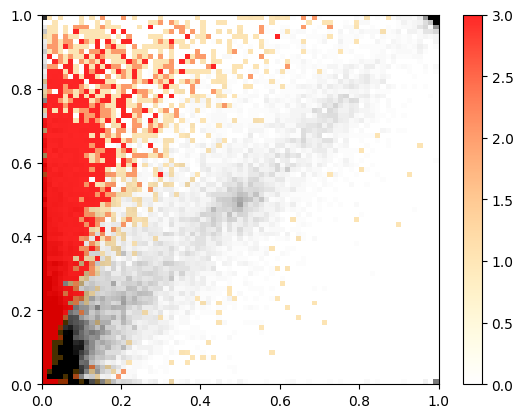

In [48]:
from matplotlib.colors import ListedColormap

# modify existing Reds colormap with a linearly fading alpha
red = plt.cm.autumn  # original colormap
fading_red = red(np.arange(red.N)) # extract colors
fading_red = fading_red[::-1]
fading_red[:, -1] = np.linspace(0.0, 0.85, red.N) # modify alpha
fading_red = ListedColormap(fading_red) # convert to colormap

plt.hist2d(means[comparison], means[comp_2], bins=(75,75), cmap='binary', vmin=0, vmax=75)
plt.hist2d(pvaluesx, pvaluesy, bins=(75,75), cmap=fading_red, vmin=0, vmax=3, range=[[0, 1], [0, 1]])
plt.xlim(0.0, 1)
plt.ylim(0.0, 1)
if 'XZ054' in edit_map:
    x_sensor = edit_map['XZ054'][3740]['Frequency'][comparison]
    y_sensor = edit_map['XZ054'][3740]['Frequency'][comp_2]
    plt.plot(x_sensor, y_sensor, marker=4, color='#c71c1c', markersize=6)
plt.colorbar()

plt.savefig(base_dir+'NG_ADAR2.svg')
plt.show()

In [ ]:
#3297977 sites
#cLIDAR = 0
#eLIDAR = 22
#gLIDAR = 4
#ADAR = 5588




#1868524
#AVP = 317
#noAVP = 113
#no vs with = 867